In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [3]:
from train_flow_sb import unflatten, object_from_config

In [4]:
api = wandb.Api()

In [5]:
# run = api.run('druhe/gw-src/ntnb1v04')
run = api.run('druhe/gw-src/1l9zbsnf')



In [6]:
config = unflatten(run.config)

In [7]:
config['model']['sb_weight']
config['model']['prior_weight']

1

In [8]:
dataset = object_from_config(config, key='dataset')
dataset = dataset(**config['dataset'])

In [9]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [10]:
tempdir = tempfile.TemporaryDirectory()

In [11]:
checkpoints = [f for f in run.files() if f.name.endswith('.pt')]

ckpt = checkpoints[-1]

ckpt_path = ckpt.download(root=tempdir.name, replace=True)

ckpt_path

<_io.TextIOWrapper name='/tmp/tmpg6mt2c5a/epoch_500_step_513525_val_loss=8.3308.pt' mode='r' encoding='UTF-8'>

In [12]:
model = object_from_config(config, key='model')(flows=flows, dataset=dataset, prior_weight=1, sb_weight=0)

In [13]:
model.load_state_dict(torch.load(ckpt_path.name), strict=False)

model.eval()

HierarchicalNormalizingFlowSB(
  (trainable_flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
  )
)

In [14]:
model.to('cuda')

HierarchicalNormalizingFlowSB(
  (trainable_flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
  )
)

In [15]:
from torch.nn.utils import _stateless

def flatten_params(parameters):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    l = [torch.flatten(p) for p in parameters]
    indices = []
    s = 0
    for p in l:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat = torch.cat(l).view(-1, 1)
    return flat, indices


def unflatten_params(flat_params, indices, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    return tuple(nn.Parameter(p) for p in l)


In [16]:
params_flat, indices = flatten_params(model.parameters())
names = list(n for n, _ in model.named_parameters())


In [17]:
loader = dataset.val_dataloader()

In [18]:
iterable = iter(loader)

In [19]:
def metropolis_adjusted_langevin_algorithm(potential, n_samples=100000, step=0.1):
    burn_in = 10000
    Z0 = torch.randn(1, 2)
    Zi = Z0
    samples = []
    pbar = tqdm(range(n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, 2)
        log_ratio = -potential(prop_Zi).mean() + potential(Zi).mean() +\
                    log_Q(potential, Zi, prop_Zi, step) - log_Q(potential, prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]


In [21]:
# likelihoods = []
# priors = []
# total = []
# i = 0
# def log_prob(params, y=None):
#     global iterable
#     global likelihoods
#     global priors
#     global total
#     global i 
#     try:
#         batch = next(iterable)
#     except StopIteration:
#         iterable = iter(loader)
#         batch = next(iterable)
    
#     gw_batch = batch[0].double().to(model.device)
    
#     params = params.to(model.device)
        
#     prior = torch.distributions.Normal(params_init.to(model.device), 32).log_prob(params)

#     params = unflatten_params(params, indices, model)
#     out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, gw_batch)    
#     ll = prior.sum() / len(out) + out.mean()
    
#     if i % 20 == 0:
#         likelihoods.append(out.mean().item())
#         priors.append(prior.sum().item() / len(out))
#         total.append(likelihoods[-1] + priors[-1])
#     i += 1
#     return ll




In [22]:

N = 1024
burn = 256
N_nuts = N + burn
step_size = 1e-3
L = 20

samples = hamiltorch.sample(
    log_prob, 
    params_init=params_init, 
    num_samples=N_nuts, 
    num_steps_per_sample=L, 
    step_size=step_size, 
    burn=burn, 
    desired_accept_rate=0.8,
    sampler=hamiltorch.Sampler.HMC_NUTS,
    debug=True)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Step: 0, Current Hamiltoninian: 52.32586891358615, Proposed Hamiltoninian: 60.680056426830255
REJECT
Step: 1, Current Hamiltoninian: 51.97452226405413, Proposed Hamiltoninian: 65.4718310714247
REJECT
Step: 2, Current Hamiltoninian: 51.44921515284768, Proposed Hamiltoninian: 51.74048493560318
Accept rho: -0.2912697827554993
Step: 3, Current Hamiltoninian: 52.264639677637916, Proposed Hamiltoninian: 52.110496987633326
Accept rho: 0.0
Step: 4, Current Hamiltoninian: 56.72688523859719, Proposed Hamiltoninian: 56.77178856786239
Accept rho: -0.044903329265196135
Step: 5, Current Hamiltoninian: 61.26272029134287, Proposed Hamiltoninian: 60.98534612196846
Accept rho: 0.0
Step: 6, Current Hamiltoninian: 66.43795123881975, Proposed Hamiltoninian: 69.47891443140094
REJECT
Step: 7, Current Hamiltoninian: 62.21851494896005, Proposed Hamiltoninian: 62.214772792742124
Accept rho: 0.0

Step: 71, Current Hamiltoninian: 52.35044270436087, Proposed Hamiltoninian: 52.52254795161632
REJECT
Step: 72, Current Hamiltoninian: 66.1386414183363, Proposed Hamiltoninian: 65.97166045131168
Accept rho: 0.0
Step: 73, Current Hamiltoninian: 76.82121891935421, Proposed Hamiltoninian: 76.76334014945112
Accept rho: 0.0
Step: 74, Current Hamiltoninian: 58.614582664659366, Proposed Hamiltoninian: 58.43852019195292
Accept rho: 0.0
Step: 75, Current Hamiltoninian: 60.20503237415672, Proposed Hamiltoninian: 58.75366182498378
Accept rho: 0.0
Step: 76, Current Hamiltoninian: 72.41655557069039, Proposed Hamiltoninian: 75.25046058904647
REJECT
Step: 77, Current Hamiltoninian: 54.388582218731884, Proposed Hamiltoninian: 54.901681723085645
Accept rho: -0.513099504353761
Step: 78, Current Hamiltoninian: 63.69852197327577, Proposed Hamiltoninian: 64.27127854518733
REJECT
Step: 79, Current Hamiltoninian: 69.37890003193147, Proposed Hamiltoninian: 70.48354889353944
REJECT
Step: 80, Current Hamiltonini

Step: 143, Current Hamiltoninian: 59.55785814445909, Proposed Hamiltoninian: 59.381064462686524
Accept rho: 0.0
Step: 144, Current Hamiltoninian: 63.698963130572885, Proposed Hamiltoninian: 62.56662648067613
Accept rho: 0.0
Step: 145, Current Hamiltoninian: 60.958394253354, Proposed Hamiltoninian: 60.942966217677096
Accept rho: 0.0
Step: 146, Current Hamiltoninian: 72.99880792346403, Proposed Hamiltoninian: 73.50516628366319
REJECT
Step: 147, Current Hamiltoninian: 58.32469915333339, Proposed Hamiltoninian: 58.31942354504587
Accept rho: 0.0
Step: 148, Current Hamiltoninian: 70.83211165293103, Proposed Hamiltoninian: 71.19556596153492
REJECT
Step: 149, Current Hamiltoninian: 54.71770164267312, Proposed Hamiltoninian: 54.83667634340513
Accept rho: -0.11897470073201077
Step: 150, Current Hamiltoninian: 64.48147585221798, Proposed Hamiltoninian: 67.52266209860491
REJECT
Step: 151, Current Hamiltoninian: 51.826983320722064, Proposed Hamiltoninian: 51.8590884737021
Accept rho: -0.03210515298

Step: 215, Current Hamiltoninian: 76.15050809354236, Proposed Hamiltoninian: 77.19428132102955
Accept rho: -1.0437732274871934
Step: 216, Current Hamiltoninian: 58.82667343874189, Proposed Hamiltoninian: 59.901930297736016
Accept rho: -1.0752568589941234
Step: 217, Current Hamiltoninian: 62.56347657662235, Proposed Hamiltoninian: 62.545137310025645
Accept rho: 0.0
Step: 218, Current Hamiltoninian: 61.85679904726527, Proposed Hamiltoninian: 61.77838081253897
Accept rho: 0.0
Step: 219, Current Hamiltoninian: 61.06136831480899, Proposed Hamiltoninian: 63.400054095853086
REJECT
Step: 220, Current Hamiltoninian: 60.23580410815215, Proposed Hamiltoninian: 60.506302853080214
Accept rho: -0.27049874492806225
Step: 221, Current Hamiltoninian: 68.09343007458496, Proposed Hamiltoninian: 68.27192729644216
Accept rho: -0.1784972218571994
Step: 222, Current Hamiltoninian: 65.2919384457345, Proposed Hamiltoninian: 65.94327261072857
Accept rho: -0.6513341649940685
Step: 223, Current Hamiltoninian: 59.

Step: 287, Current Hamiltoninian: 47.284302121860996, Proposed Hamiltoninian: 46.369687387634414
Accept rho: 0.0
Step: 288, Current Hamiltoninian: 55.33249018895235, Proposed Hamiltoninian: 54.915649299273326
Accept rho: 0.0
Step: 289, Current Hamiltoninian: 64.14715269074264, Proposed Hamiltoninian: 63.070241625679714
Accept rho: 0.0
Step: 290, Current Hamiltoninian: 68.39397557433198, Proposed Hamiltoninian: 68.24475378662683
Accept rho: 0.0
Step: 291, Current Hamiltoninian: 69.15991008179765, Proposed Hamiltoninian: 69.88422783867685
REJECT
Step: 292, Current Hamiltoninian: 48.12309416944214, Proposed Hamiltoninian: 48.09927176073009
Accept rho: 0.0
Step: 293, Current Hamiltoninian: 66.14798859554062, Proposed Hamiltoninian: 66.54400840101576
REJECT
Step: 294, Current Hamiltoninian: 53.853938345820694, Proposed Hamiltoninian: 53.90856616834375
Accept rho: -0.054627822523052316
Step: 295, Current Hamiltoninian: 67.94039691147549, Proposed Hamiltoninian: 68.40168313997856
Accept rho: 

Step: 359, Current Hamiltoninian: 66.85237254191571, Proposed Hamiltoninian: 65.85038750498902
Accept rho: 0.0
Step: 360, Current Hamiltoninian: 75.08489432723309, Proposed Hamiltoninian: 74.80818951040465
Accept rho: 0.0
Step: 361, Current Hamiltoninian: 69.46945807820691, Proposed Hamiltoninian: 70.18080695793022
Accept rho: -0.7113488797233032
Step: 362, Current Hamiltoninian: 54.57165051952285, Proposed Hamiltoninian: 54.548612086434474
Accept rho: 0.0
Step: 363, Current Hamiltoninian: 52.5132610352185, Proposed Hamiltoninian: 52.05377940646504
Accept rho: 0.0
Step: 364, Current Hamiltoninian: 64.72202014149659, Proposed Hamiltoninian: 64.220479952578
Accept rho: 0.0
Step: 365, Current Hamiltoninian: 59.59206617927522, Proposed Hamiltoninian: 59.730733163379696
Accept rho: -0.13866698410447498
Step: 366, Current Hamiltoninian: 63.05789781192108, Proposed Hamiltoninian: 64.74202363517107
REJECT
Step: 367, Current Hamiltoninian: 71.67408488657344, Proposed Hamiltoninian: 72.766047971

Step: 502, Current Hamiltoninian: 81.46874842682026, Proposed Hamiltoninian: 80.76846092816447
Accept rho: 0.0
Step: 503, Current Hamiltoninian: 65.87003081732396, Proposed Hamiltoninian: 64.47152988721555
Accept rho: 0.0
Step: 504, Current Hamiltoninian: 69.85262488356224, Proposed Hamiltoninian: 69.73029459960985
Accept rho: 0.0
Step: 505, Current Hamiltoninian: 71.01183191056367, Proposed Hamiltoninian: 72.15896072558292
REJECT
Step: 506, Current Hamiltoninian: 61.05504255908673, Proposed Hamiltoninian: 61.151142705269706
Accept rho: -0.09610014618297669
Step: 507, Current Hamiltoninian: 64.01328124047332, Proposed Hamiltoninian: 62.05817273669734
Accept rho: 0.0
Step: 508, Current Hamiltoninian: 61.03311315396281, Proposed Hamiltoninian: 61.46332779372231
Accept rho: -0.43021463975949814
Step: 509, Current Hamiltoninian: 67.70640852696549, Proposed Hamiltoninian: 66.86947023038674
Accept rho: 0.0
Step: 510, Current Hamiltoninian: 58.0456827184092, Proposed Hamiltoninian: 58.5266098

Step: 646, Current Hamiltoninian: 59.28862167732237, Proposed Hamiltoninian: 59.20819469481616
Accept rho: 0.0
Step: 647, Current Hamiltoninian: 53.887521281838644, Proposed Hamiltoninian: 54.37095378389416
REJECT
Step: 648, Current Hamiltoninian: 64.71467434210788, Proposed Hamiltoninian: 63.835143821940925
Accept rho: 0.0
Step: 649, Current Hamiltoninian: 68.96866601919604, Proposed Hamiltoninian: 68.93270780456079
Accept rho: 0.0
Step: 650, Current Hamiltoninian: 68.02810478288632, Proposed Hamiltoninian: 68.29116947185504
Accept rho: -0.2630646889687256
Step: 651, Current Hamiltoninian: 64.86748936382891, Proposed Hamiltoninian: 65.96848153542352
REJECT
Step: 652, Current Hamiltoninian: 64.36004564403972, Proposed Hamiltoninian: 63.3831720016995
Accept rho: 0.0
Step: 653, Current Hamiltoninian: 68.3228362226639, Proposed Hamiltoninian: 69.2826160653557
REJECT
Step: 654, Current Hamiltoninian: 75.33743198385561, Proposed Hamiltoninian: 75.23664798692882
Accept rho: 0.0
Step: 655, Cu

Step: 718, Current Hamiltoninian: 53.209820003433734, Proposed Hamiltoninian: 53.62179936483201
REJECT
Step: 719, Current Hamiltoninian: 58.54300926456702, Proposed Hamiltoninian: 58.97952400173384
REJECT
Step: 720, Current Hamiltoninian: 81.58539285080522, Proposed Hamiltoninian: 81.35250272415308
Accept rho: 0.0
Step: 721, Current Hamiltoninian: 69.09073209297443, Proposed Hamiltoninian: 69.02271260511985
Accept rho: 0.0
Step: 722, Current Hamiltoninian: 65.53082041045126, Proposed Hamiltoninian: 64.41722522338574
Accept rho: 0.0
Step: 723, Current Hamiltoninian: 66.45219712119268, Proposed Hamiltoninian: 66.52450353532174
Accept rho: -0.07230641412905925
Step: 724, Current Hamiltoninian: 69.44119504203739, Proposed Hamiltoninian: 69.90824961630848
Accept rho: -0.46705457427108854
Step: 725, Current Hamiltoninian: 56.07718014305141, Proposed Hamiltoninian: 55.51301914124465
Accept rho: 0.0
Step: 726, Current Hamiltoninian: 64.47791575278877, Proposed Hamiltoninian: 65.24483753771112


Step: 791, Current Hamiltoninian: 68.14507151902431, Proposed Hamiltoninian: 69.8563635909455
REJECT
Step: 792, Current Hamiltoninian: 66.30017167879267, Proposed Hamiltoninian: 67.17252655217817
Accept rho: -0.872354873385504
Step: 793, Current Hamiltoninian: 62.213837023491436, Proposed Hamiltoninian: 62.56395493997682
REJECT
Step: 794, Current Hamiltoninian: 71.86356953252195, Proposed Hamiltoninian: 72.41000039219057
Accept rho: -0.546430859668618
Step: 795, Current Hamiltoninian: 68.10612061791679, Proposed Hamiltoninian: 67.60798292810524
Accept rho: 0.0
Step: 796, Current Hamiltoninian: 61.92673246674113, Proposed Hamiltoninian: 61.385776639149796
Accept rho: 0.0
Step: 797, Current Hamiltoninian: 61.890083288910134, Proposed Hamiltoninian: 61.86856337541923
Accept rho: 0.0
Step: 798, Current Hamiltoninian: 75.25874258249443, Proposed Hamiltoninian: 75.82000708737496
Accept rho: -0.5612645048805263
Step: 799, Current Hamiltoninian: 63.8841037399384, Proposed Hamiltoninian: 63.413

Step: 863, Current Hamiltoninian: 60.411515204111915, Proposed Hamiltoninian: 60.041782877518074
Accept rho: 0.0
Step: 864, Current Hamiltoninian: 59.52212686420627, Proposed Hamiltoninian: 59.337274610311056
Accept rho: 0.0
Step: 865, Current Hamiltoninian: 60.88147089134894, Proposed Hamiltoninian: 59.921437390266874
Accept rho: 0.0
Step: 866, Current Hamiltoninian: 59.28154261239435, Proposed Hamiltoninian: 60.15743082019871
REJECT
Step: 867, Current Hamiltoninian: 56.53513480432561, Proposed Hamiltoninian: 55.72446830250378
Accept rho: 0.0
Step: 868, Current Hamiltoninian: 55.8423034622631, Proposed Hamiltoninian: 56.90417132843315
Accept rho: -1.0618678661700542
Step: 869, Current Hamiltoninian: 69.07732387329409, Proposed Hamiltoninian: 69.3908062300037
Accept rho: -0.31348235670961344
Step: 870, Current Hamiltoninian: 58.163362884555006, Proposed Hamiltoninian: 57.632653563953625
Accept rho: 0.0
Step: 871, Current Hamiltoninian: 65.58850646980213, Proposed Hamiltoninian: 65.3623

Step: 935, Current Hamiltoninian: 71.2171201671015, Proposed Hamiltoninian: 71.70435306506903
Accept rho: -0.4872328979675302
Step: 936, Current Hamiltoninian: 79.13282661959013, Proposed Hamiltoninian: 79.88372254627832
REJECT
Step: 937, Current Hamiltoninian: 53.906616685760255, Proposed Hamiltoninian: 53.886125790900984
Accept rho: 0.0
Step: 938, Current Hamiltoninian: 56.26788539519392, Proposed Hamiltoninian: 56.28977857590824
Accept rho: -0.021893180714315008
Step: 939, Current Hamiltoninian: 64.37241866121539, Proposed Hamiltoninian: 64.07065385344536
Accept rho: 0.0
Step: 940, Current Hamiltoninian: 67.5778676850206, Proposed Hamiltoninian: 68.35275008343851
REJECT
Step: 941, Current Hamiltoninian: 68.75117751536834, Proposed Hamiltoninian: 68.99162111499383
REJECT
Step: 942, Current Hamiltoninian: 65.86004924553946, Proposed Hamiltoninian: 65.80027951950534
Accept rho: 0.0
Step: 943, Current Hamiltoninian: 71.0072983064282, Proposed Hamiltoninian: 71.39393711731866
REJECT
Step

Step: 1006, Current Hamiltoninian: 63.32287534534828, Proposed Hamiltoninian: 62.99542720362978
Accept rho: 0.0
Step: 1007, Current Hamiltoninian: 59.412070144602964, Proposed Hamiltoninian: 59.05450699634986
Accept rho: 0.0
Step: 1008, Current Hamiltoninian: 64.85157142613963, Proposed Hamiltoninian: 65.08539632833948
Accept rho: -0.2338249021998564
Step: 1009, Current Hamiltoninian: 54.346607708489344, Proposed Hamiltoninian: 54.75879962155033
Accept rho: -0.4121919130609868
Step: 1010, Current Hamiltoninian: 58.48557143708905, Proposed Hamiltoninian: 58.30546552492082
Accept rho: 0.0
Step: 1011, Current Hamiltoninian: 52.20597487899847, Proposed Hamiltoninian: 52.50968250422896
Accept rho: -0.3037076252304942
Step: 1012, Current Hamiltoninian: 64.75794676631304, Proposed Hamiltoninian: 65.5958147551836
Accept rho: -0.8378679888705562
Step: 1013, Current Hamiltoninian: 57.19942941292201, Proposed Hamiltoninian: 56.692623365768995
Accept rho: 0.0
Step: 1014, Current Hamiltoninian: 68.

Step: 1075, Current Hamiltoninian: 64.92625370278, Proposed Hamiltoninian: 65.13277143477248
Accept rho: -0.20651773199247714
Step: 1076, Current Hamiltoninian: 77.08993273455809, Proposed Hamiltoninian: 76.87833124283085
Accept rho: 0.0
Step: 1077, Current Hamiltoninian: 56.305656423407676, Proposed Hamiltoninian: 56.54026158020526
Accept rho: -0.23460515679758487
Step: 1078, Current Hamiltoninian: 59.187241065557686, Proposed Hamiltoninian: 59.174379807733885
Accept rho: 0.0
Step: 1079, Current Hamiltoninian: 61.21388893461205, Proposed Hamiltoninian: 61.684326672761074
REJECT
Step: 1080, Current Hamiltoninian: 71.92632801761846, Proposed Hamiltoninian: 71.51445140976732
Accept rho: 0.0
Step: 1081, Current Hamiltoninian: 61.642767921944916, Proposed Hamiltoninian: 62.07629448256319
Accept rho: -0.4335265606182759
Step: 1082, Current Hamiltoninian: 59.502382371695234, Proposed Hamiltoninian: 59.090075061935735
Accept rho: 0.0
Step: 1083, Current Hamiltoninian: 53.36286180023386, Propo

Step: 1146, Current Hamiltoninian: 67.79417222478153, Proposed Hamiltoninian: 66.8559210634831
Accept rho: 0.0
Step: 1147, Current Hamiltoninian: 69.44606225582041, Proposed Hamiltoninian: 69.54022529152446
Accept rho: -0.0941630357040566
Step: 1148, Current Hamiltoninian: 66.02492942298161, Proposed Hamiltoninian: 66.74876797048802
REJECT
Step: 1149, Current Hamiltoninian: 56.92558750727359, Proposed Hamiltoninian: 56.73402788722755
Accept rho: 0.0
Step: 1150, Current Hamiltoninian: 64.6522111139419, Proposed Hamiltoninian: 63.74393967581271
Accept rho: 0.0
Step: 1151, Current Hamiltoninian: 60.24041676630646, Proposed Hamiltoninian: 60.17932243443687
Accept rho: 0.0
Step: 1152, Current Hamiltoninian: 73.3663050353542, Proposed Hamiltoninian: 73.2659162362772
Accept rho: 0.0
Step: 1153, Current Hamiltoninian: 62.593641670747196, Proposed Hamiltoninian: 62.884311311776834
REJECT
Step: 1154, Current Hamiltoninian: 58.11041868921257, Proposed Hamiltoninian: 58.74849730688911
Accept rho: 

Step: 1217, Current Hamiltoninian: 55.62495943728035, Proposed Hamiltoninian: 55.8998369324476
Accept rho: -0.2748774951672459
Step: 1218, Current Hamiltoninian: 61.01728461368353, Proposed Hamiltoninian: 60.66640350680061
Accept rho: 0.0
Step: 1219, Current Hamiltoninian: 72.46447500281054, Proposed Hamiltoninian: 72.31710510366267
Accept rho: 0.0
Step: 1220, Current Hamiltoninian: 57.21635303501618, Proposed Hamiltoninian: 57.82470836561172
REJECT
Step: 1221, Current Hamiltoninian: 50.19056090887719, Proposed Hamiltoninian: 50.335052103202216
Accept rho: -0.14449119432502755
Step: 1222, Current Hamiltoninian: 60.04127880365457, Proposed Hamiltoninian: 60.59106796946324
Accept rho: -0.5497891658086687
Step: 1223, Current Hamiltoninian: 54.43864022388213, Proposed Hamiltoninian: 54.874505075975534
Accept rho: -0.43586485209340253
Step: 1224, Current Hamiltoninian: 55.348141171112125, Proposed Hamiltoninian: 55.5920530267178
Accept rho: -0.24391185560567408
Step: 1225, Current Hamiltoni

In [ ]:
samples = torch.stack(samples)



In [24]:
axes_names = []
axes = []

for n, ax in dataset.grid.items():
    axes_names.append(n)
    axes.append(ax)

d = dataset.dimensionality
m1, m2, z, chi = np.stack(np.meshgrid(*axes, indexing="ij")).reshape(d, -1)

resolutions = [len(ax) for ax in axes]

input = np.stack([m1, m2, z, chi], axis=-1)
input = torch.from_numpy(input)

In [25]:
input = input.to(model.device)

In [26]:
def functional_call(model, flat_params):
    
    params = unflatten_params(flat_params, indices, model)

    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, input)    
    return out

In [27]:
model.base_dist

pyro.distributions.torch.Normal

In [28]:
with torch.no_grad():
    logprob = functional_call(model, params_init.to(model.device))
prob = logprob.exp().view(*resolutions)


Got 2D data, reshaping to 3D


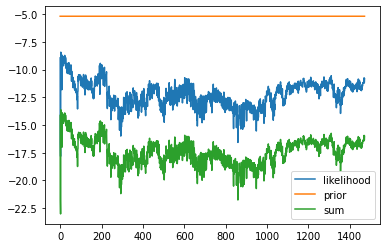

In [29]:
plt.plot(likelihoods, label='likelihood')
plt.plot(priors, label='prior')
plt.plot(total, label='sum')
plt.legend()

# plt.ylim(-20, -5)

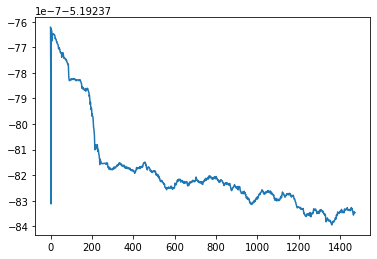

In [30]:
plt.plot(priors)


In [31]:
pm1m2 = prob.sum((2, 3)).cpu()

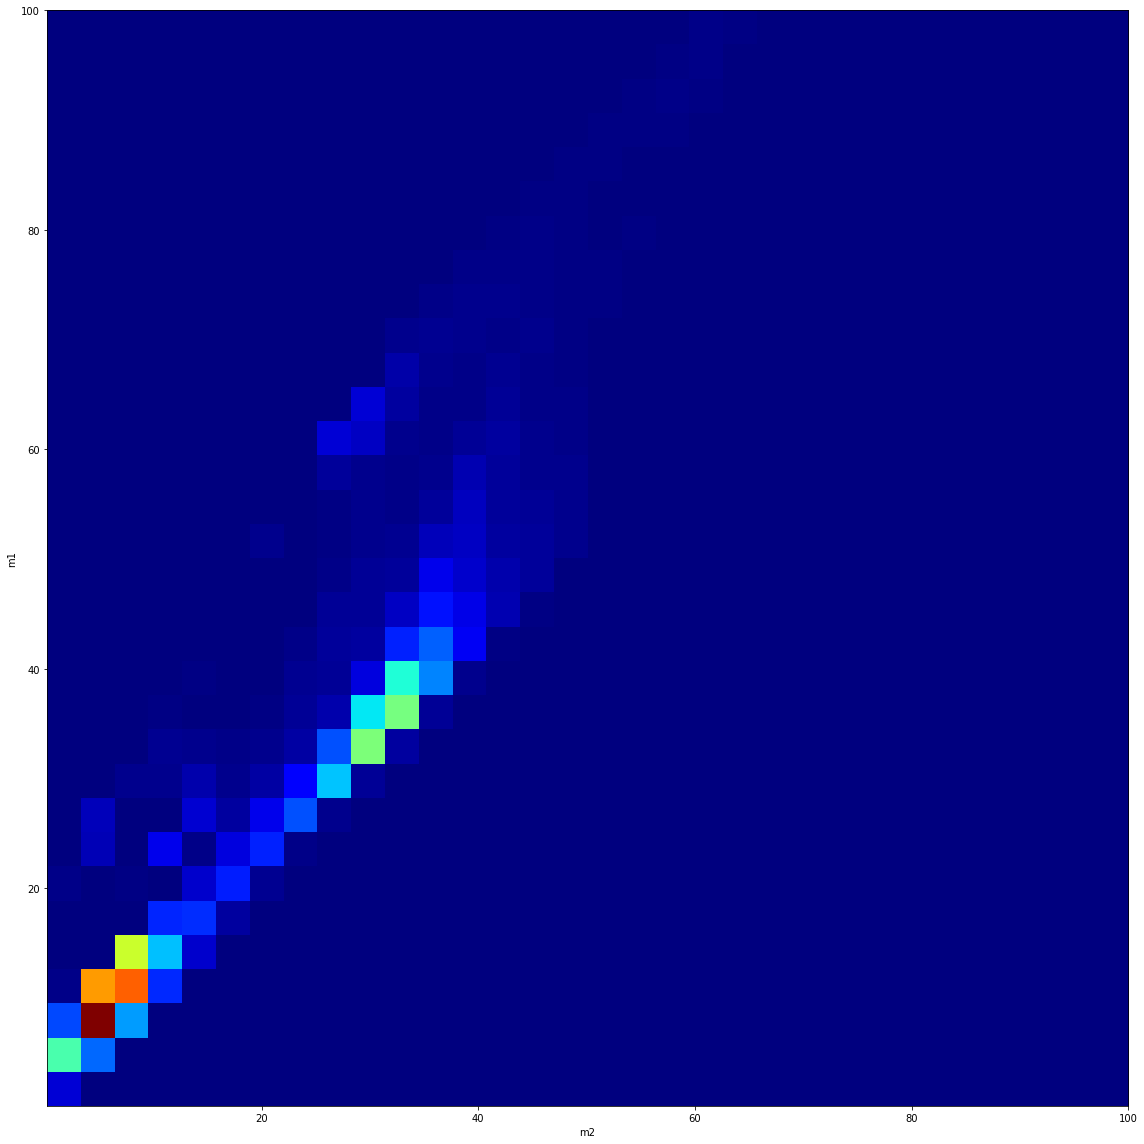

In [32]:
fig = plt.figure(figsize=(16, 16), facecolor="white")
plt.imshow(
    pm1m2,
    cmap="jet",
    origin="lower",
    extent=(
        axes[1][0],
        axes[1][-1],
        axes[0][0],
        axes[0][-1],
    ),  # origin='lower' changes the order
    aspect="auto",
)

plt.xlabel(axes_names[1])  # origin='lower' changes the order
plt.ylabel(axes_names[0])
plt.tight_layout()

In [33]:
pm1= prob.sum((1, 2, 3)).cpu()

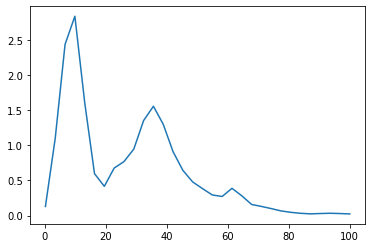

In [34]:
plt.plot(axes[0], pm1)
# plt.yscale('log')

In [35]:
import tqdm

In [36]:
samples.shape

torch.Size([1024, 90])

In [37]:
samples = samples.cuda()

In [38]:
model = model.cuda()

In [39]:
input = input.cuda()

In [ ]:
probs = []
for sample in tqdm.tqdm(samples):
    with torch.no_grad():
        logprob = functional_call(model, sample)
    prob = logprob.exp().view(*resolutions).cpu()
    probs.append(prob)

  0%|                                          | 2/1024 [00:00<00:59, 17.16it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  1%|▏                                         | 6/1024 [00:00<00:57, 17.56it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  1%|▍                                        | 10/1024 [00:00<00:55, 18.23it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  1%|▌                                        | 14/1024 [00:00<00:54, 18.47it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  2%|▋                                        | 18/1024 [00:00<00:54, 18.59it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  2%|▉                                        | 22/1024 [00:01<00:53, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  3%|█                                        | 26/1024 [00:01<00:53, 18.67it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  3%|█▏                                       | 30/1024 [00:01<00:53, 18.68it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  3%|█▎                                       | 34/1024 [00:01<00:52, 18.69it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  4%|█▌                                       | 38/1024 [00:02<00:52, 18.69it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  4%|█▋                                       | 42/1024 [00:02<00:52, 18.68it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  4%|█▊                                       | 46/1024 [00:02<00:52, 18.69it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  5%|██                                       | 50/1024 [00:02<00:52, 18.69it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  5%|██▏                                      | 54/1024 [00:02<00:51, 18.68it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  6%|██▎                                      | 58/1024 [00:03<00:51, 18.68it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  6%|██▍                                      | 62/1024 [00:03<00:51, 18.68it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  6%|██▋                                      | 66/1024 [00:03<00:51, 18.66it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  7%|██▊                                      | 70/1024 [00:03<00:51, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  7%|██▉                                      | 74/1024 [00:03<00:50, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  8%|███                                      | 78/1024 [00:04<00:50, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  8%|███▎                                     | 82/1024 [00:04<00:50, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  8%|███▍                                     | 86/1024 [00:04<00:50, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  9%|███▌                                     | 90/1024 [00:04<00:50, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


  9%|███▊                                     | 94/1024 [00:05<00:49, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 10%|███▉                                     | 98/1024 [00:05<00:49, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 10%|███▉                                    | 102/1024 [00:05<00:49, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 10%|████▏                                   | 106/1024 [00:05<00:49, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 11%|████▎                                   | 110/1024 [00:05<00:49, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 11%|████▍                                   | 114/1024 [00:06<00:48, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 12%|████▌                                   | 118/1024 [00:06<00:48, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 12%|████▊                                   | 122/1024 [00:06<00:48, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 12%|████▉                                   | 126/1024 [00:06<00:48, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 13%|█████                                   | 130/1024 [00:06<00:47, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 13%|█████▏                                  | 134/1024 [00:07<00:47, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 13%|█████▍                                  | 138/1024 [00:07<00:47, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 14%|█████▌                                  | 142/1024 [00:07<00:47, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 14%|█████▋                                  | 146/1024 [00:07<00:47, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 15%|█████▊                                  | 150/1024 [00:08<00:46, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 15%|██████                                  | 154/1024 [00:08<00:46, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 15%|██████▏                                 | 158/1024 [00:08<00:46, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 16%|██████▎                                 | 162/1024 [00:08<00:46, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 16%|██████▍                                 | 166/1024 [00:08<00:46, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 17%|██████▋                                 | 170/1024 [00:09<00:45, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 17%|██████▊                                 | 174/1024 [00:09<00:45, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 17%|██████▉                                 | 178/1024 [00:09<00:45, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 18%|███████                                 | 182/1024 [00:09<00:45, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 18%|███████▎                                | 186/1024 [00:09<00:44, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 19%|███████▍                                | 190/1024 [00:10<00:44, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 19%|███████▌                                | 194/1024 [00:10<00:44, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 19%|███████▋                                | 198/1024 [00:10<00:44, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 20%|███████▉                                | 202/1024 [00:10<00:44, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 20%|████████                                | 206/1024 [00:11<00:43, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 21%|████████▏                               | 210/1024 [00:11<00:43, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 21%|████████▎                               | 214/1024 [00:11<00:43, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 21%|████████▌                               | 218/1024 [00:11<00:43, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 22%|████████▋                               | 222/1024 [00:11<00:43, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 22%|████████▊                               | 226/1024 [00:12<00:42, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 22%|████████▉                               | 230/1024 [00:12<00:42, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 23%|█████████▏                              | 234/1024 [00:12<00:42, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 23%|█████████▎                              | 238/1024 [00:12<00:42, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 24%|█████████▍                              | 242/1024 [00:12<00:41, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 24%|█████████▌                              | 246/1024 [00:13<00:41, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 24%|█████████▊                              | 250/1024 [00:13<00:41, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 25%|█████████▉                              | 254/1024 [00:13<00:41, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 25%|██████████                              | 258/1024 [00:13<00:41, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 26%|██████████▏                             | 262/1024 [00:14<00:40, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 26%|██████████▍                             | 266/1024 [00:14<00:40, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 26%|██████████▌                             | 270/1024 [00:14<00:40, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 27%|██████████▋                             | 274/1024 [00:14<00:40, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 27%|██████████▊                             | 278/1024 [00:14<00:40, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 28%|███████████                             | 282/1024 [00:15<00:39, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 28%|███████████▏                            | 286/1024 [00:15<00:39, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 28%|███████████▎                            | 290/1024 [00:15<00:39, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 29%|███████████▍                            | 294/1024 [00:15<00:39, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 29%|███████████▋                            | 298/1024 [00:16<00:38, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 29%|███████████▊                            | 302/1024 [00:16<00:38, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 30%|███████████▉                            | 306/1024 [00:16<00:38, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 30%|████████████                            | 310/1024 [00:16<00:38, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 31%|████████████▎                           | 314/1024 [00:16<00:38, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 31%|████████████▍                           | 318/1024 [00:17<00:37, 18.61it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 31%|████████████▌                           | 322/1024 [00:17<00:37, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 32%|████████████▋                           | 326/1024 [00:17<00:37, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 32%|████████████▉                           | 330/1024 [00:17<00:37, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 33%|█████████████                           | 334/1024 [00:17<00:37, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 33%|█████████████▏                          | 338/1024 [00:18<00:36, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 33%|█████████████▎                          | 342/1024 [00:18<00:36, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 34%|█████████████▌                          | 346/1024 [00:18<00:36, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 34%|█████████████▋                          | 350/1024 [00:18<00:36, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 35%|█████████████▊                          | 354/1024 [00:19<00:35, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 35%|█████████████▉                          | 358/1024 [00:19<00:35, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 35%|██████████████▏                         | 362/1024 [00:19<00:35, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 36%|██████████████▎                         | 366/1024 [00:19<00:35, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 36%|██████████████▍                         | 370/1024 [00:19<00:35, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 37%|██████████████▌                         | 374/1024 [00:20<00:34, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 37%|██████████████▊                         | 378/1024 [00:20<00:34, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 37%|██████████████▉                         | 382/1024 [00:20<00:34, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 38%|███████████████                         | 386/1024 [00:20<00:34, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 38%|███████████████▏                        | 390/1024 [00:20<00:34, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 38%|███████████████▍                        | 394/1024 [00:21<00:33, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 39%|███████████████▌                        | 398/1024 [00:21<00:33, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 39%|███████████████▋                        | 402/1024 [00:21<00:33, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 40%|███████████████▊                        | 406/1024 [00:21<00:33, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 40%|████████████████                        | 410/1024 [00:22<00:32, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 40%|████████████████▏                       | 414/1024 [00:22<00:32, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 41%|████████████████▎                       | 418/1024 [00:22<00:32, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 41%|████████████████▍                       | 422/1024 [00:22<00:32, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 42%|████████████████▋                       | 426/1024 [00:22<00:32, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 42%|████████████████▊                       | 430/1024 [00:23<00:31, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 42%|████████████████▉                       | 434/1024 [00:23<00:31, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 43%|█████████████████                       | 438/1024 [00:23<00:31, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 43%|█████████████████▎                      | 442/1024 [00:23<00:31, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 44%|█████████████████▍                      | 446/1024 [00:23<00:31, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 44%|█████████████████▌                      | 450/1024 [00:24<00:30, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 44%|█████████████████▋                      | 454/1024 [00:24<00:30, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 45%|█████████████████▉                      | 458/1024 [00:24<00:30, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 45%|██████████████████                      | 462/1024 [00:24<00:30, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 46%|██████████████████▏                     | 466/1024 [00:25<00:29, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 46%|██████████████████▎                     | 470/1024 [00:25<00:29, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 46%|██████████████████▌                     | 474/1024 [00:25<00:29, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 47%|██████████████████▋                     | 478/1024 [00:25<00:29, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 47%|██████████████████▊                     | 482/1024 [00:25<00:29, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 47%|██████████████████▉                     | 486/1024 [00:26<00:28, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 48%|███████████████████▏                    | 490/1024 [00:26<00:28, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 48%|███████████████████▎                    | 494/1024 [00:26<00:28, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 49%|███████████████████▍                    | 498/1024 [00:26<00:28, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 49%|███████████████████▌                    | 502/1024 [00:26<00:27, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 49%|███████████████████▊                    | 506/1024 [00:27<00:27, 18.63it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 50%|███████████████████▉                    | 510/1024 [00:27<00:27, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 50%|████████████████████                    | 514/1024 [00:27<00:27, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 51%|████████████████████▏                   | 518/1024 [00:27<00:27, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 51%|████████████████████▍                   | 522/1024 [00:28<00:26, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 51%|████████████████████▌                   | 526/1024 [00:28<00:26, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 52%|████████████████████▋                   | 530/1024 [00:28<00:26, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 52%|████████████████████▊                   | 534/1024 [00:28<00:26, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 53%|█████████████████████                   | 538/1024 [00:28<00:26, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 53%|█████████████████████▏                  | 542/1024 [00:29<00:25, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 53%|█████████████████████▎                  | 546/1024 [00:29<00:25, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 54%|█████████████████████▍                  | 550/1024 [00:29<00:25, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 54%|█████████████████████▋                  | 554/1024 [00:29<00:25, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 54%|█████████████████████▊                  | 558/1024 [00:29<00:24, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 55%|█████████████████████▉                  | 562/1024 [00:30<00:24, 18.64it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 55%|██████████████████████                  | 566/1024 [00:30<00:24, 18.65it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 56%|██████████████████████▎                 | 570/1024 [00:30<00:24, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 56%|██████████████████████▍                 | 574/1024 [00:30<00:24, 18.62it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 56%|██████████████████████▌                 | 578/1024 [00:31<00:23, 18.61it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 57%|██████████████████████▋                 | 582/1024 [00:31<00:23, 18.61it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 57%|██████████████████████▉                 | 586/1024 [00:31<00:23, 18.60it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 58%|███████████████████████                 | 590/1024 [00:31<00:23, 18.59it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 58%|███████████████████████▏                | 594/1024 [00:31<00:23, 18.59it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 58%|███████████████████████▎                | 598/1024 [00:32<00:22, 18.59it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 59%|███████████████████████▌                | 602/1024 [00:32<00:22, 18.59it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 59%|███████████████████████▋                | 606/1024 [00:32<00:22, 18.59it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 60%|███████████████████████▊                | 610/1024 [00:32<00:22, 18.59it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 60%|███████████████████████▉                | 614/1024 [00:32<00:22, 18.59it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 60%|████████████████████████▏               | 618/1024 [00:33<00:21, 18.58it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 61%|████████████████████████▎               | 622/1024 [00:33<00:21, 18.59it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 61%|████████████████████████▍               | 626/1024 [00:33<00:21, 18.59it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 62%|████████████████████████▌               | 630/1024 [00:33<00:21, 18.60it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 62%|████████████████████████▊               | 634/1024 [00:34<00:20, 18.60it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 62%|████████████████████████▉               | 638/1024 [00:34<00:20, 18.60it/s]

Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D
Got 2D data, reshaping to 3D


 63%|█████████████████████████               | 642/1024 [00:34<00:20, 18.59it/s]

In [ ]:
probs = torch.stack(probs)

In [ ]:
probs.shape

In [ ]:
m1 = probs.sum((2, 3, 4)).cpu().numpy()

In [ ]:
m1_med = np.median(m1, axis=0)

In [ ]:
m1_005 = np.percentile(m1, 5, axis=0)
m1_095 = np.percentile(m1, 95, axis=0)

In [ ]:
plt.plot(axes[0], m1_med)
plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
plt.yscale('log')
plt.ylim((1e-5, 3))

In [ ]:
plt.plot(axes[0], pm1)
plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
plt.yscale('log')
plt.ylim((1e-5, 3))